# Explaining Medical Insurance Price Prediction Models

In [2]:
#import libraries
import pandas as pd
import scipy
import sklearn
import numpy as np
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, cv, DMatrix, plot_importance

In [3]:
df = pd.read_csv('Medical_insurance.csv')

### Source of dataset: https://www.kaggle.com/datasets/harishkumardatalab/medical-insurance-price-prediction

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Questions:
1. What are the most important factors that affect medical expenses?
2. How well can machine learning models predict medical expenses?
3. How can machine learning models be used to improve the efficiency and profitability of health insurance companies?


## First look at data

In [5]:
df.shape

(2772, 7)

In [6]:
#null values and duplicates
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


In [7]:
df.duplicated().sum()


1435

In [8]:
df = df.drop_duplicates()

In [9]:
df.shape

(1337, 7)

In [10]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [11]:
df.corr(numeric_only=True) 
# age seems to be the most important feature - can try to infer from the model - SHAP values

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


## Data Preprocessing

### Get boolean variables for 'male' and 'smokes'

In [12]:
male = np.zeros(df.shape[0])

In [13]:
male[df['sex']=='male']=1

In [14]:
df['male']= male

In [15]:
df

,age,sex,bmi,children,smoker,region,charges,male
0,19,female,27.900,0,yes,southwest,16884.92400,0.0
1,18,male,33.770,1,no,southeast,1725.55230,1.0
2,28,male,33.000,3,no,southeast,4449.46200,1.0
3,33,male,22.705,0,no,northwest,21984.47061,1.0
4,32,male,28.880,0,no,northwest,3866.85520,1.0
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1.0
1334,18,female,31.920,0,no,northeast,2205.98080,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0.0


In [16]:
#sex, smoker --> convert to boolean
#region --> dummy variables

#make functions
def smoker_convert(smoker):
    if smoker == 'yes':
        return 1
    else:
        return 0
    

In [17]:
df['smokes'] = df.loc[:,'smoker'].apply(smoker_convert)

In [18]:
df

,age,sex,bmi,children,smoker,region,charges,male,smokes
0,19,female,27.900,0,yes,southwest,16884.92400,0.0,1
1,18,male,33.770,1,no,southeast,1725.55230,1.0,0
2,28,male,33.000,3,no,southeast,4449.46200,1.0,0
3,33,male,22.705,0,no,northwest,21984.47061,1.0,0
4,32,male,28.880,0,no,northwest,3866.85520,1.0,0
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,1.0,0
1334,18,female,31.920,0,no,northeast,2205.98080,0.0,0
1335,18,female,36.850,0,no,southeast,1629.83350,0.0,0
1336,21,female,25.800,0,no,southwest,2007.94500,0.0,0


## Get dummy variables for region

In [19]:
df['region'] = df['region'].astype('category')
df_new = pd.get_dummies(df, columns=['region'])

In [20]:
df_new

,age,sex,bmi,children,smoker,charges,male,smokes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,16884.92400,0.0,1,0,0,0,1
1,18,male,33.770,1,no,1725.55230,1.0,0,0,0,1,0
2,28,male,33.000,3,no,4449.46200,1.0,0,0,0,1,0
3,33,male,22.705,0,no,21984.47061,1.0,0,0,1,0,0
4,32,male,28.880,0,no,3866.85520,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830,1.0,0,0,1,0,0
1334,18,female,31.920,0,no,2205.98080,0.0,0,1,0,0,0
1335,18,female,36.850,0,no,1629.83350,0.0,0,0,0,1,0
1336,21,female,25.800,0,no,2007.94500,0.0,0,0,0,0,1


In [21]:
df_clean = df_new.drop(['sex', 'smoker'], axis=1)

In [22]:
df_clean

,age,bmi,children,charges,male,smokes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1,0,0,0,1
1,18,33.770,1,1725.55230,1.0,0,0,0,1,0
2,28,33.000,3,4449.46200,1.0,0,0,0,1,0
3,33,22.705,0,21984.47061,1.0,0,0,1,0,0
4,32,28.880,0,3866.85520,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1.0,0,0,1,0,0
1334,18,31.920,0,2205.98080,0.0,0,1,0,0,0
1335,18,36.850,0,1629.83350,0.0,0,0,0,1,0
1336,21,25.800,0,2007.94500,0.0,0,0,0,0,1


In [23]:
#look at correlation
df_clean.corr()

,age,bmi,children,charges,male,smokes,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.109344,0.041536,0.298308,-0.019814,-0.025587,0.001868,0.001495,-0.012311,0.009415
bmi,0.109344,1.000000,0.012755,0.198401,0.046397,0.003746,-0.138178,-0.136138,0.270057,-0.006211
children,0.041536,0.012755,1.000000,0.067389,0.017848,0.007331,-0.023202,0.026044,-0.023492,0.021538
charges,0.298308,0.198401,0.067389,1.000000,0.058044,0.787234,0.005945,-0.038695,0.073578,-0.043637
male,-0.019814,0.046397,0.017848,0.058044,1.000000,0.076596,-0.002008,-0.012482,0.017578,-0.003767
smokes,-0.025587,0.003746,0.007331,0.787234,0.076596,1.000000,0.002597,-0.036321,0.068282,-0.037168
region_northeast,0.001868,-0.138178,-0.023202,0.005945,-0.002008,0.002597,1.000000,-0.319842,-0.345909,-0.320493
region_northwest,0.001495,-0.136138,0.026044,-0.038695,-0.012482,-0.036321,-0.319842,1.000000,-0.345909,-0.320493
region_southeast,-0.012311,0.270057,-0.023492,0.073578,0.017578,0.068282,-0.345909,-0.345909,1.000000,-0.346614
region_southwest,0.009415,-0.006211,0.021538,-0.043637,-0.003767,-0.037168,-0.320493,-0.320493,-0.346614,1.000000


In [24]:
#linear regression
#homoskedasticity --> normalize
#features are normally distributed

## EDA:
 data itself(bar, hist)
 compare variables (scatter plot)

In [25]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [26]:
rng = np.arange(df_clean['age'].min(), df_clean['age'].max(), 0.1)
norm.pdf(df_clean['age'].mean(), df_clean['age'].std())

8.841196836550673e-139

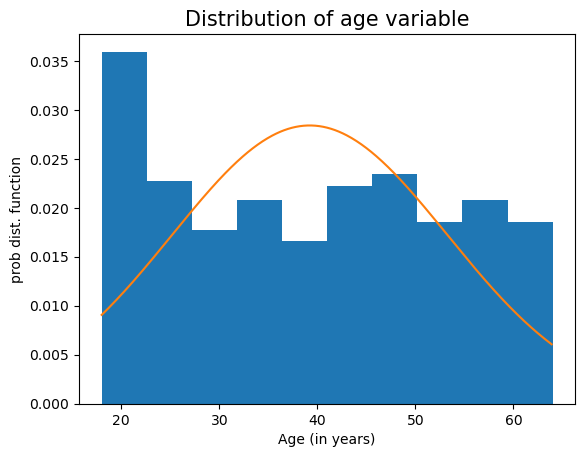

In [27]:
plt.hist(df_clean['age'], density=True) #, bins=20)
rng = np.arange(df_clean['age'].min(), df_clean['age'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, df_clean['age'].mean(), df_clean['age'].std()))
plt.title('Distribution of age variable', size=15)
plt.ylabel('prob dist. function')
plt.xlabel('Age (in years)')
plt.show()

* The age variable is roughly normally distributed

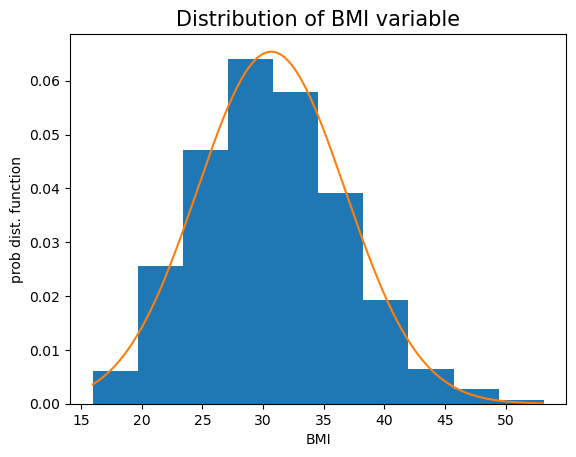

In [28]:
plt.hist(df_clean['bmi'], density=True) #, bins=20)
rng = np.arange(df_clean['bmi'].min(), df_clean['bmi'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, df_clean['bmi'].mean(), df_clean['bmi'].std()))
plt.title('Distribution of BMI variable', size=15)
plt.ylabel('prob dist. function')
plt.xlabel('BMI')
plt.show()

* The age variable is roughly normally distributed

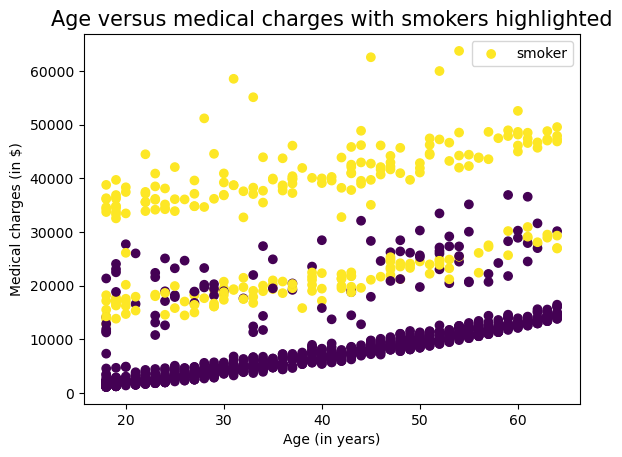

In [29]:
plt.scatter(df_clean['age'], df_clean['charges'], c= df_clean['smokes'], label=['smoker'])
plt.legend(labels = ['smoker'])
plt.title('Age versus medical charges with smokers highlighted', size=15)
plt.ylabel('Medical charges (in $)')
plt.xlabel('Age (in years)')
plt.show()

* On average, within the same age groups, smokers tend to have higher medical charges.

In [30]:
# get features and labels
y =  df_clean['charges']
x = df_clean.drop(['charges'], axis=1)

## Standardize and scale columns

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
sc =  StandardScaler()

In [33]:
x_standardized = pd.DataFrame(sc.fit_transform(x))

In [34]:
x_standardized

,0,1,2,3,4,5,6,7,8
0,-1.440418,-0.453160,-0.909234,-1.009771,1.969660,-0.565546,-0.565546,-0.611638,1.764609
1,-1.511647,0.509422,-0.079442,0.990324,-0.507702,-0.565546,-0.565546,1.634955,-0.566698
2,-0.799350,0.383155,1.580143,0.990324,-0.507702,-0.565546,-0.565546,1.634955,-0.566698
3,-0.443201,-1.305052,-0.909234,0.990324,-0.507702,-0.565546,1.768203,-0.611638,-0.566698
4,-0.514431,-0.292456,-0.909234,0.990324,-0.507702,-0.565546,1.768203,-0.611638,-0.566698
...,...,...,...,...,...,...,...,...,...
1332,0.767704,0.050269,1.580143,0.990324,-0.507702,-0.565546,1.768203,-0.611638,-0.566698
1333,-1.511647,0.206053,-0.909234,-1.009771,-0.507702,1.768203,-0.565546,-0.611638,-0.566698
1334,-1.511647,1.014490,-0.909234,-1.009771,-0.507702,-0.565546,-0.565546,1.634955,-0.566698
1335,-1.297958,-0.797524,-0.909234,-1.009771,-0.507702,-0.565546,-0.565546,-0.611638,1.764609


In [35]:
from sklearn.model_selection import train_test_split

In [36]:
# train, test split
train_x, test_x, train_y, test_y = train_test_split(x_standardized, y)

# ML models for regression
1. Linear Regression
2. Decision Tree Regressors
3. Random Forest Regressors
4. XGBoost Regressors

## Fit Linear Regression model

In [37]:
lr = LinearRegression()

In [38]:
lr.fit(train_x, train_y)

LinearRegression()

In [39]:
train_pred = lr.predict(train_x)

In [40]:
test_pred = lr.predict(test_x)

In [41]:
r2_score(train_pred, train_y)

0.6742098291891749

In [42]:
r2_score(test_pred, test_y)

0.6414663953375068

In [43]:
mean_squared_error(train_pred, train_y)

36977694.31238314

In [44]:
mean_squared_error(test_pred, test_y)

35782311.45912462

### Compute Feature importance using SHAP

In [45]:
explainer = shap.LinearExplainer(lr, train_x)
shap_values = explainer.shap_values(test_x)

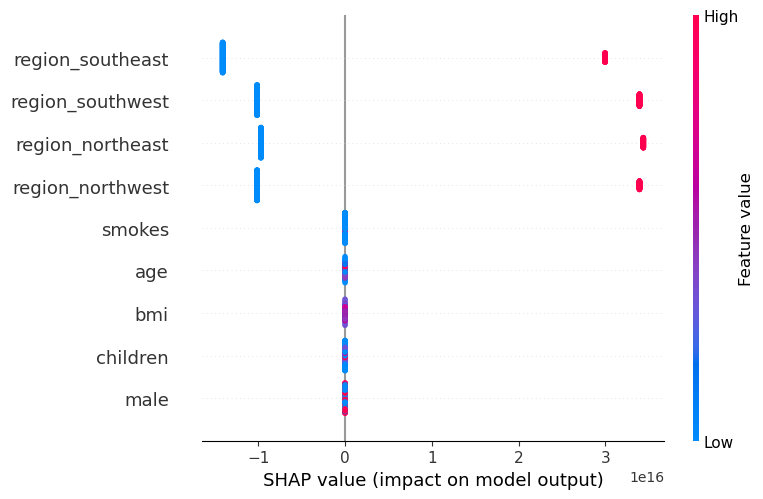

In [46]:
shap.summary_plot(shap_values, test_x, feature_names=x.columns)


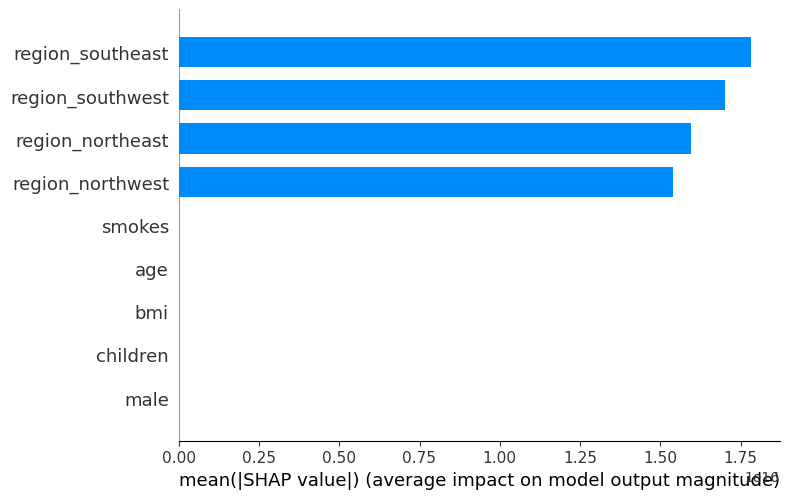

In [47]:
shap.summary_plot(shap_values, test_x, plot_type="bar", feature_names = x.columns)

## Fit Random Forest Regressor

In [48]:
rf = RandomForestRegressor(n_estimators=1000)

In [49]:
rf.fit(train_x, train_y)

RandomForestRegressor(n_estimators=1000)

In [50]:
train_pred_rf = rf.predict(train_x)
test_pred = rf.predict(test_x)

In [51]:
mean_squared_error(train_pred, train_y)

36977694.31238314

In [52]:
mean_squared_error(test_pred, test_y)

25082865.434604857

In [53]:
r2_score(test_pred, test_y)

0.7967864802675643

In [54]:
r2_score(train_pred_rf, train_y)

0.9771239699643486

### Compute feature importance
1. Using scikit-learn feature importance method

In [55]:
rf.feature_importances_

array([0.13579139, 0.20448218, 0.02101346, 0.00485128, 0.61657752,
       0.00556282, 0.00530674, 0.00421731, 0.00219731])

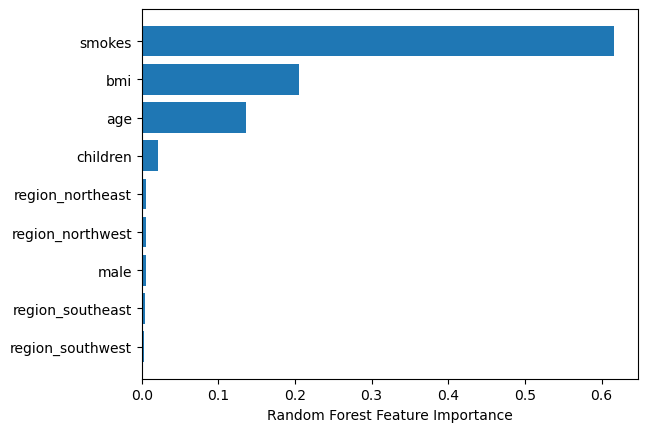

In [56]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

2. Using SHAP

In [57]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(test_x)

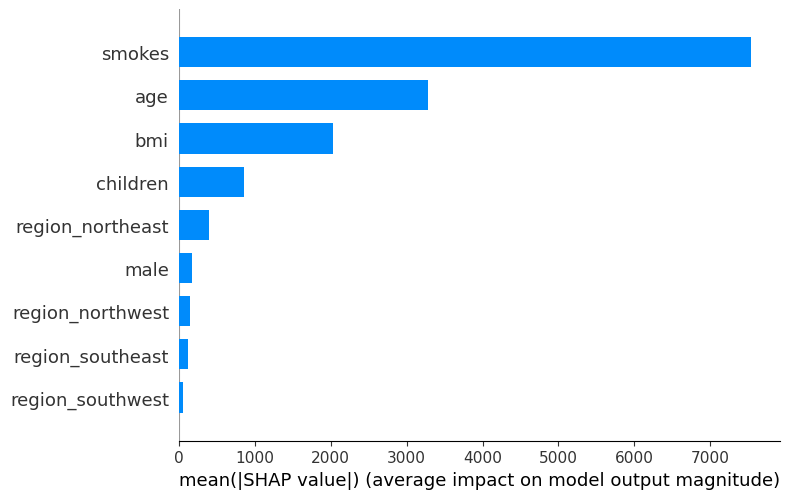

In [58]:
shap.summary_plot(shap_values, test_x, plot_type="bar", feature_names = x.columns)

In [59]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute
shap.TreeExplainer(rf).shap_interaction_values(test_x[:100])

array([[[ 6.58717626e+03, -3.99785196e+02,  6.41895143e+01, ...,
         -5.28099647e+01, -2.36029291e+01,  2.82983318e+00],
        [-3.99785196e+02, -2.17866241e+03,  1.61331030e+02, ...,
         -9.74314541e+00, -7.26486845e+00,  2.81986607e+00],
        [ 6.41895143e+01,  1.61331030e+02, -9.91294763e+02, ...,
         -1.56979902e-01, -1.40865882e+01,  4.36954038e+00],
        ...,
        [-5.28099647e+01, -9.74314541e+00, -1.56979902e-01, ...,
         -5.43475564e+01, -1.56897936e+00, -1.00529631e-02],
        [-2.36029291e+01, -7.26486845e+00, -1.40865882e+01, ...,
         -1.56897936e+00, -4.90490595e+01,  5.97084235e-01],
        [ 2.82983318e+00,  2.81986607e+00,  4.36954038e+00, ...,
         -1.00529631e-02,  5.97084235e-01,  8.71046987e+00]],

       [[-3.19841911e+03,  3.70275700e+01, -3.21323707e+01, ...,
         -7.31536317e+01,  3.26751291e+01, -1.92025601e+01],
        [ 3.70275700e+01,  1.49249739e+03,  3.63650376e+01, ...,
         -9.77589182e+00,  2.13191421e

TypeError: object of type 'int' has no len()

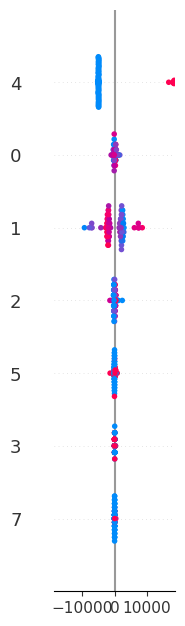

In [60]:
shap_interaction_values = shap.TreeExplainer(rf).shap_interaction_values(test_x.iloc[:100,:])
shap.summary_plot(shap_interaction_values, test_x.iloc[:100,:])


## Fit Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier()


In [ ]:
train_y = train_y.astype(int)

In [ ]:
dt.fit(train_x, train_y)

In [ ]:
train_pred_dt = dt.predict(train_x)
test_pred = dt.predict(test_x)

In [ ]:
mean_squared_error(test_pred, test_y)

In [ ]:
r2_score(test_pred, test_y)

In [ ]:
r2_score(train_pred_dt, train_y)

In [ ]:
mean_squared_error(train_pred_dt, train_y)

### Compute feature importance
1. Using scikit-learn feature importance method

In [ ]:
sorted_idx = dt.feature_importances_.argsort()
plt.barh(x.columns[sorted_idx], dt.feature_importances_[sorted_idx])
plt.xlabel("Decision Trees Classifier Feature Importance")
plt.show()

2. Using SHAP

In [ ]:
## not working - some bug


In [ ]:
##

## Fit XGBoost Regressor

In [ ]:
xgb = XGBRegressor()

In [ ]:
xgb.fit(train_x, train_y)

In [ ]:
mean_squared_error(xgb.predict(train_x), train_y)

In [ ]:
mean_squared_error(xgb.predict(test_x), test_y)

In [ ]:
r2_score(xgb.predict(test_x), test_y)

In [ ]:
r2_score(xgb.predict(train_x), train_y)

### Compute feature importance
1. Using built-in feature importance method

In [ ]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(x.columns)
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
plt.title('Feature importance of XGBoost Regressor', size=20)
plt.show()

2. Using SHAP

In [ ]:
explainer = shap.Explainer(xgb)

In [ ]:
shap_values = explainer(test_x)

In [ ]:
shap.summary_plot(shap_values, test_x, plot_type="bar", feature_names = x.columns)

In [ ]:
x.columns

In [ ]:
shap.summary_plot(shap_values, test_x, feature_names=x.columns)